# Plot ELG chains
This jupyter notebook contains some code to make plots of the bestfits and contours for the abacus cubic ELG fits to both the mock mean and individual realisations.

In [5]:
# Import some necessary modules
import os
import sys
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer     

sys.path.append("../../Barry/")     # Change this so that it points to where you have Barry installed

from barry.samplers import DynestySampler
from barry.config import setup
from barry.models import PowerBeutler2017, CorrBeutler2017
from barry.datasets.dataset_power_spectrum import PowerSpectrum_DESI_KP4
from barry.datasets.dataset_correlation_function import CorrelationFunction_DESI_KP4
from barry.fitter import Fitter
from barry.models.model import Correction # class for applying corrections to the likelihood function 
from barry.utils import weighted_avg_and_cov # function for getting avg and covariance 

pfn = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG_bestnuisance/output/desi_kp4_abacus_cubic_ELG_bestnuisance.fitter.pkl"
    
with open(pfn, 'rb') as pickle_file:
    fitter = pickle.load(pickle_file)
    


This code segment reads in the chains, plots the bestfit model vs. data and prepares stuff for contour plots and summary files

DESI KP4 Abacus CubicBox Pk ELG Prerecon mock mean 2 mean


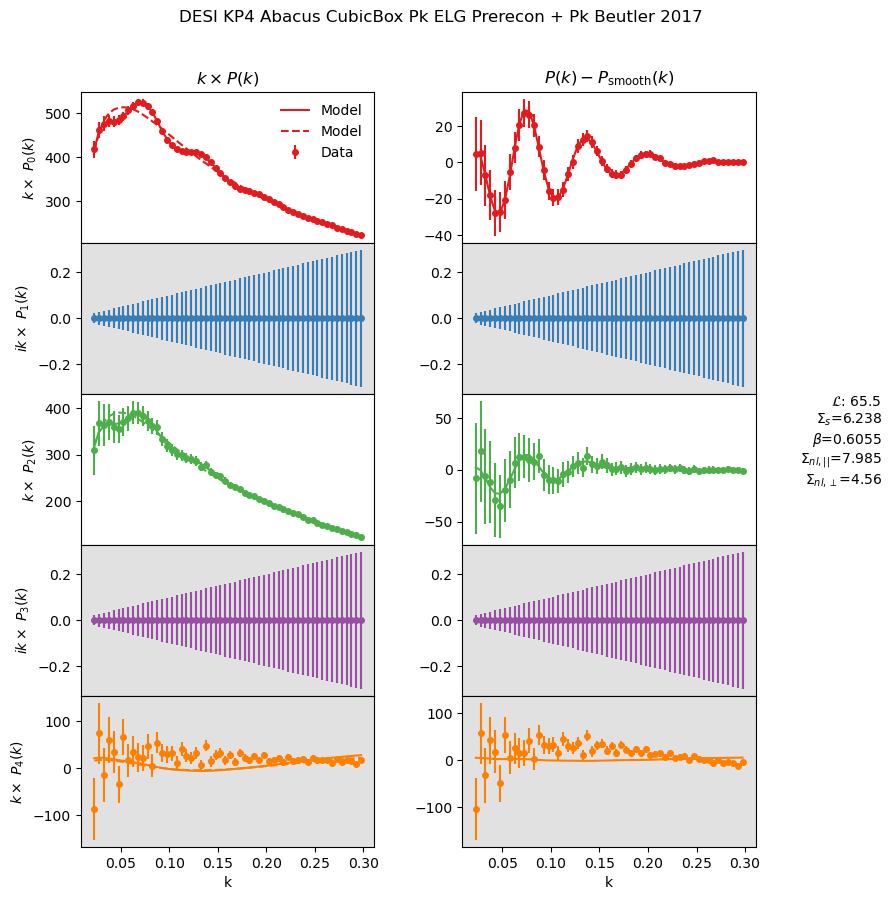

DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 0 2 0
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 1 2 1
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 2 2 2
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 3 2 3
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 4 2 4
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 5 2 5
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 6 2 6
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 7 2 7
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 8 2 8
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 9 2 9
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 10 2 10


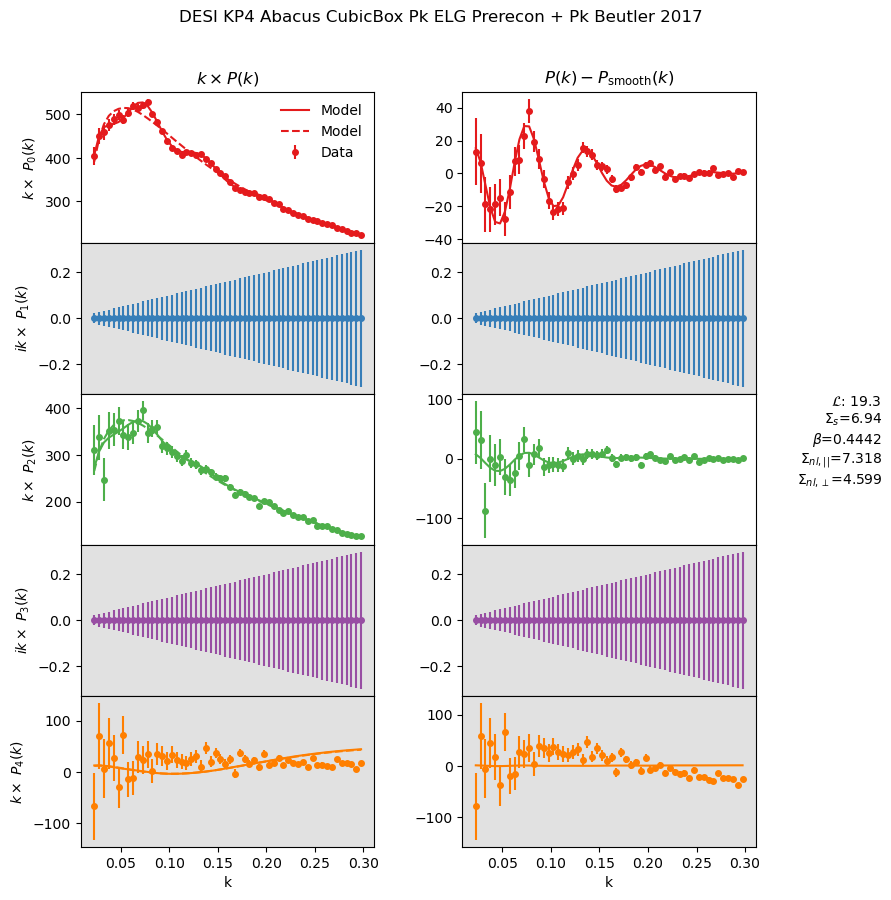

DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 11 2 11
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 12 2 12
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 13 2 13
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 14 2 14
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 15 2 15
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 16 2 16
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 17 2 17
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 18 2 18
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 19 2 19
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 20 2 20
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 21 2 21
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 22 2 22
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 23 2 23
DESI KP4 Abacus CubicBox Pk ELG Prerecon realisation 24 2 24
DESI KP4 Abacus CubicBox Pk ELG Recon mock mean 3 mean


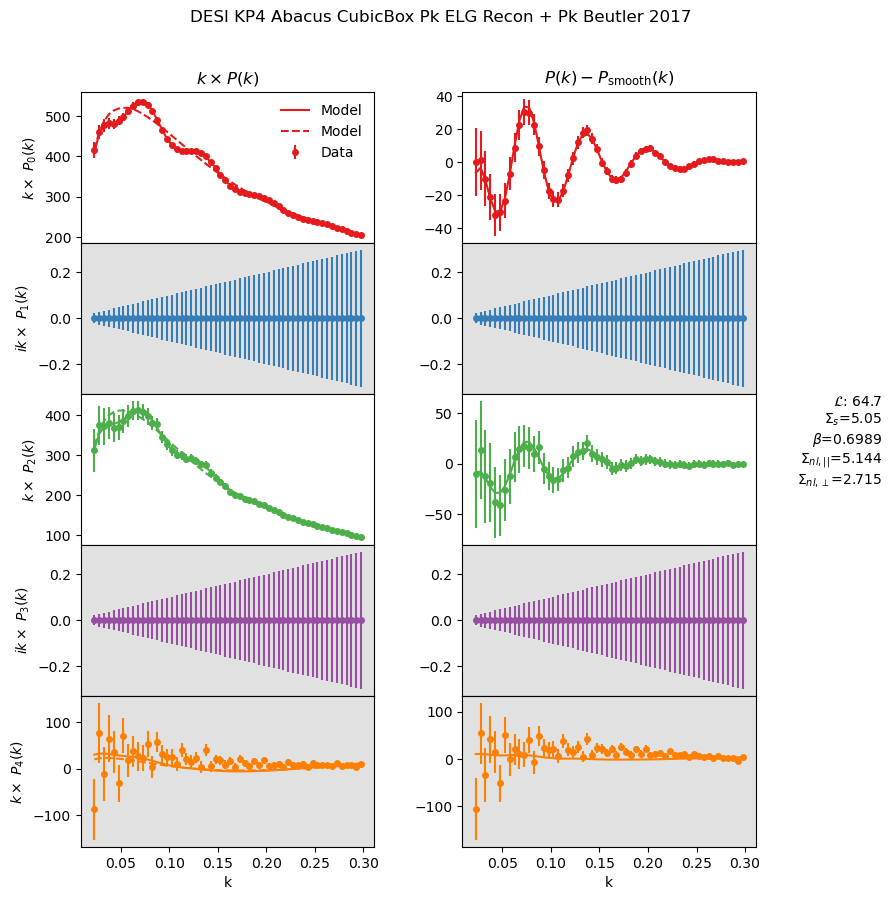

DESI KP4 Abacus CubicBox Pk ELG Recon realisation 0 3 0
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 1 3 1
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 2 3 2
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 3 3 3
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 4 3 4
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 5 3 5
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 6 3 6
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 7 3 7
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 8 3 8
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 9 3 9
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 10 3 10


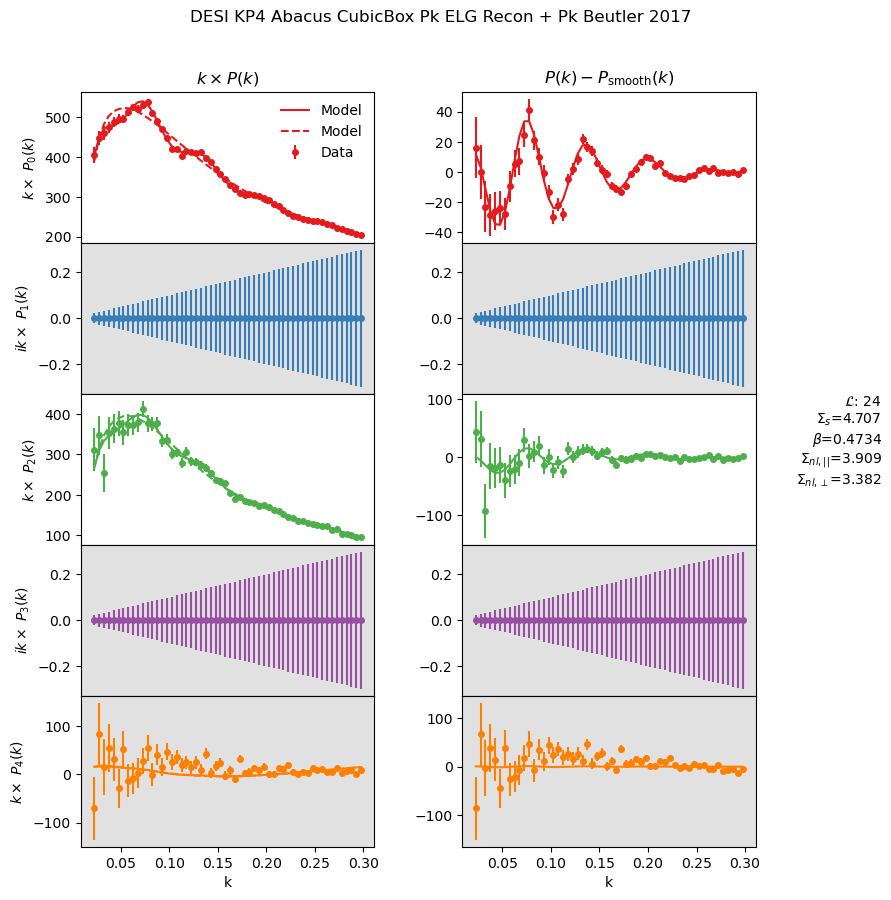

DESI KP4 Abacus CubicBox Pk ELG Recon realisation 11 3 11
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 12 3 12
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 13 3 13
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 14 3 14
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 15 3 15
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 16 3 16
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 17 3 17
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 18 3 18
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 19 3 19
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 20 3 20
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 21 3 21
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 22 3 22
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 23 3 23
DESI KP4 Abacus CubicBox Pk ELG Recon realisation 24 3 24
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon mock mean 2 mean


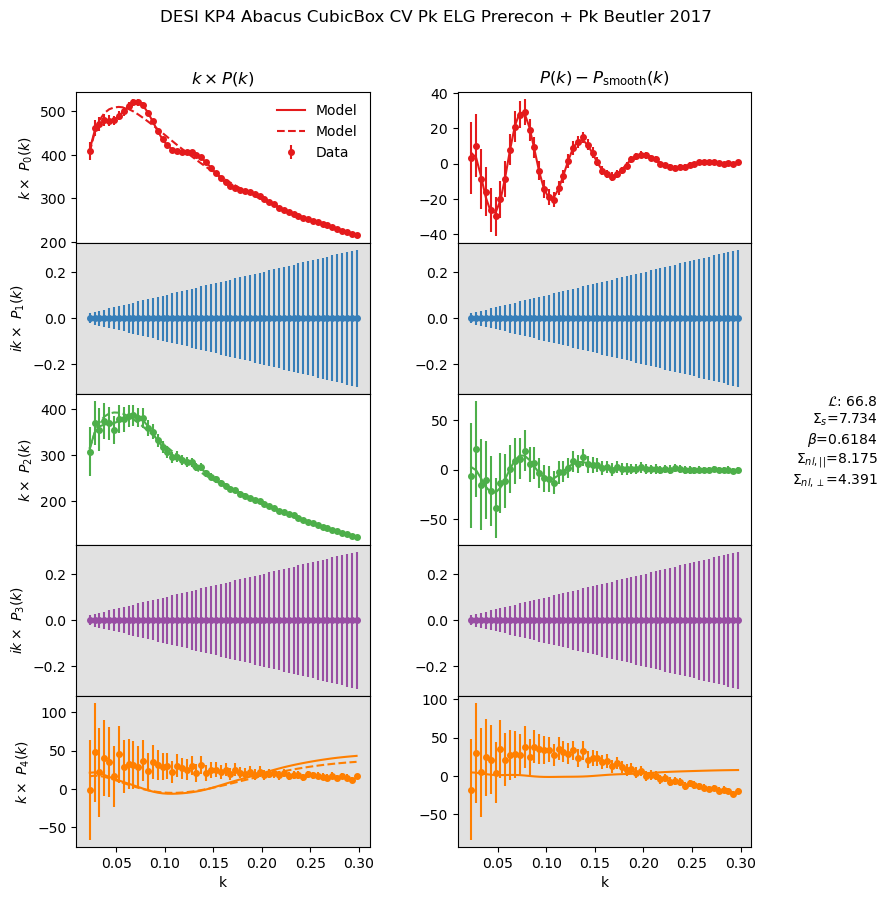

DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 0 2 0
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 1 2 1
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 2 2 2
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 3 2 3
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 4 2 4
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 5 2 5
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 6 2 6
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 7 2 7
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 8 2 8
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 9 2 9
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 10 2 10


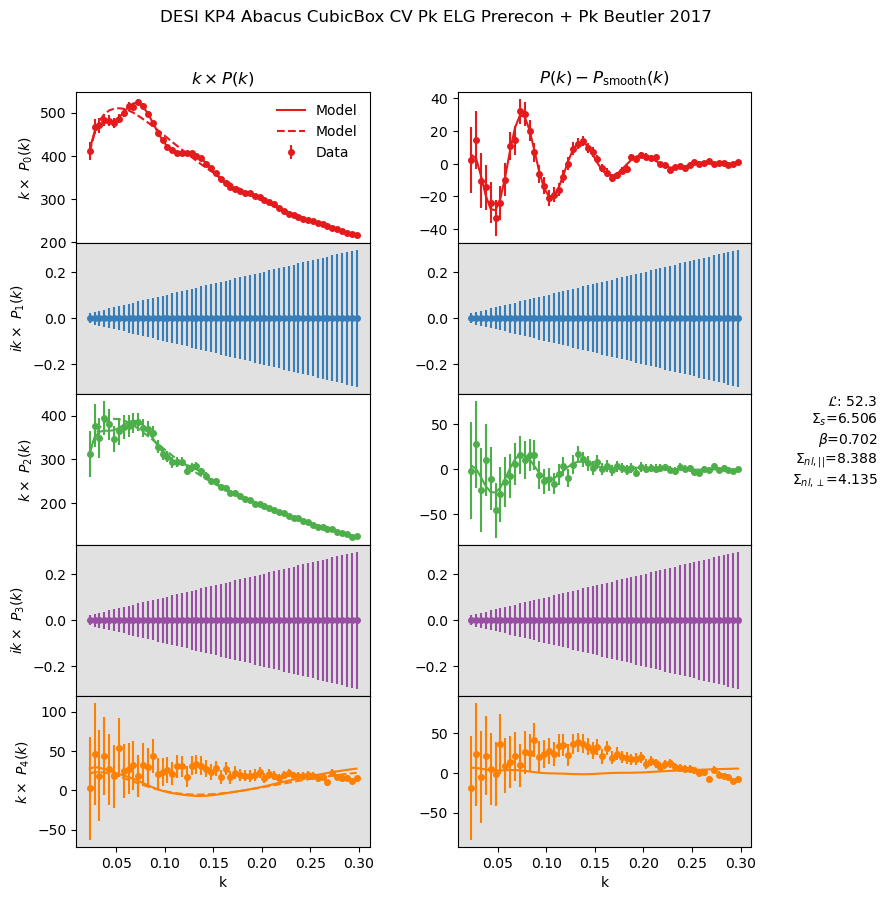

DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 11 2 11
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 12 2 12
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 13 2 13
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 14 2 14
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 15 2 15
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 16 2 16
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 17 2 17
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 18 2 18
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 19 2 19
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 20 2 20
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 21 2 21
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 22 2 22
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 23 2 23
DESI KP4 Abacus CubicBox CV Pk ELG Prerecon realisation 24 2 24
DESI KP4 Abacus CubicBox CV Pk ELG Recon mock mean 3 mean


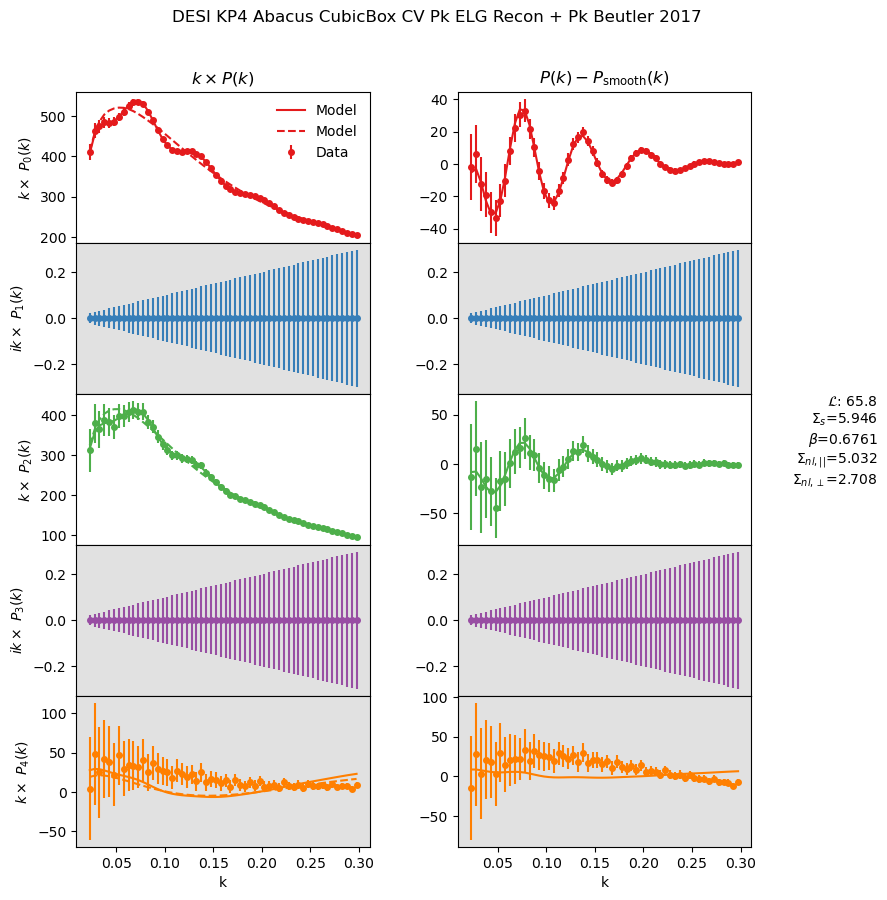

DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 0 3 0
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 1 3 1
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 2 3 2
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 3 3 3
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 4 3 4
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 5 3 5
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 6 3 6
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 7 3 7
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 8 3 8
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 9 3 9
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 10 3 10


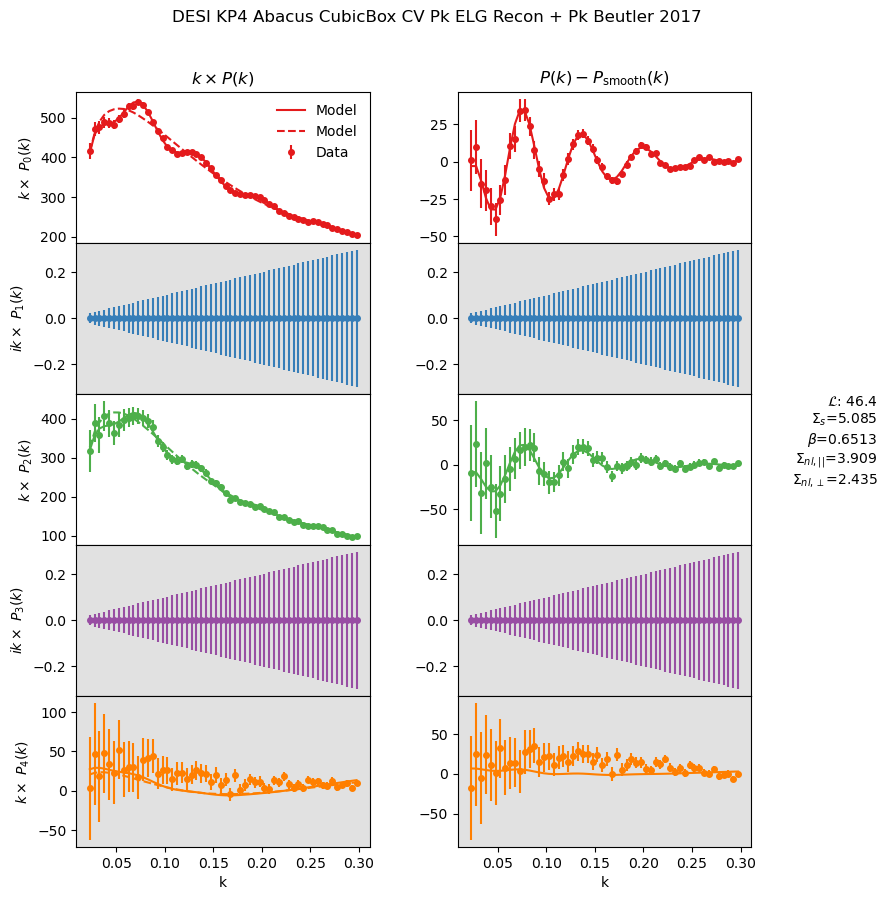

DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 11 3 11
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 12 3 12
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 13 3 13
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 14 3 14
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 15 3 15
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 16 3 16
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 17 3 17
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 18 3 18
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 19 3 19
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 20 3 20
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 21 3 21
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 22 3 22
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 23 3 23
DESI KP4 Abacus CubicBox CV Pk ELG Recon realisation 24 3 24


In [7]:
logging.info("Creating plots")

fitname = []
datanames = ["CV_Xi_Prerecon", "CV_Xi_Recon", "CV_Pk_Prerecon", "CV_Pk_Recon"]
c = [ChainConsumer(), ChainConsumer(), ChainConsumer(), ChainConsumer()]

# Loop over all the chains
stats = {k: [] for k in datanames}
output = {k: [] for k in datanames}
for posterior, weight, chain, evidence, model, data, extra in fitter.load():

    if "Pk" not in extra["name"]:# or "CV" not in extra["name"]:
       #print('test')
       continue 
        
    recon_bin = 0 if "Prerecon" in extra["name"] else 1
    data_bin = 0 if "Xi" in extra["name"] else 1
    realisation = str(extra["name"].split()[-1]) if "realisation" in extra["name"] else "mean"
    chain_bin = int(2.0 * data_bin + recon_bin)
    print(extra["name"], chain_bin, realisation)
    
    # Store the chain in a dictionary with parameter names
    df = pd.DataFrame(chain, columns=model.get_labels())
                                                      
    # Get the MAP (maximum a posteriori) point and set the model up at this point
    model.set_data(data)
    r_s = model.camb.get_data()["r_s"]
    max_post = posterior.argmax()
    params = df.loc[max_post]
    params_dict = model.get_param_dict(chain[max_post])
    for name, val in params_dict.items():
        model.set_default(name, val)

    # Get some useful properties of the fit, and plot the MAP model against the data if it's the mock mean or realisation 10 (chosen randomly!)
    display = True if realisation == "mean" or realisation == "10" else False
    new_chi_squared, dof, bband, mods, smooths = model.plot(params_dict, display=display)

    # Add the chain or MAP to the Chainconsumer plots
    extra.pop("realisation", None)
    if realisation == "mean":
        c[chain_bin].add_chain(df, weights=weight, **extra, plot_contour=True, plot_point=False, show_as_1d_prior=False)
    else:
        c[chain_bin].add_marker(params, **extra, marker_size=80)

    # Compute some summary statistics and add them to a dictionary
    
    params = [
                "$\\Sigma_{nl,||}$",
                "$\\Sigma_{nl,\\perp}$",
                "$\\Sigma_s$"
            ]
    
    mean, cov = weighted_avg_and_cov(
        df[
            params
        ],
        weight,
        axis=0,
    )
    
    stats[datanames[chain_bin]].append(
        [mean[0], mean[1], mean[2], np.sqrt(cov[0,0]), np.sqrt(cov[1,1]), np.sqrt(cov[2,2])]
    )

    output[datanames[chain_bin]].append(
        f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {np.sqrt(cov[2, 2]):6.4f}, {new_chi_squared:7.3f}, {dof:4d}"
    )

Plot the contour plots and output the summary statistics

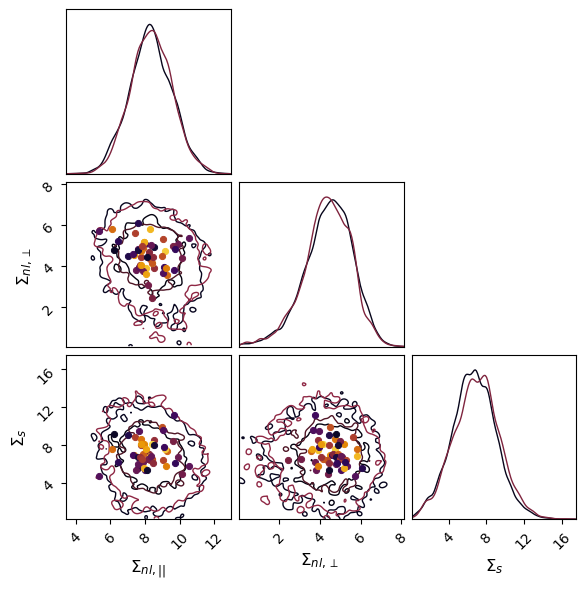

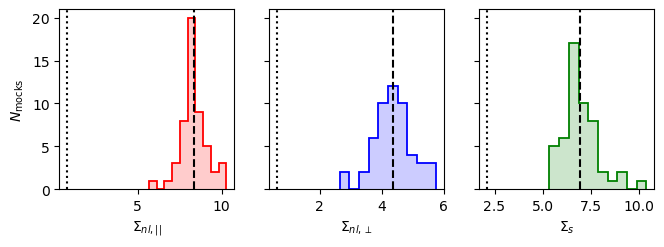

[8.35013276 4.36629309 6.94846747 1.19547791 1.15727369 2.31029896]
[0.80147619 0.63711649 0.9508529  0.0698621  0.0758296  0.1807003 ]


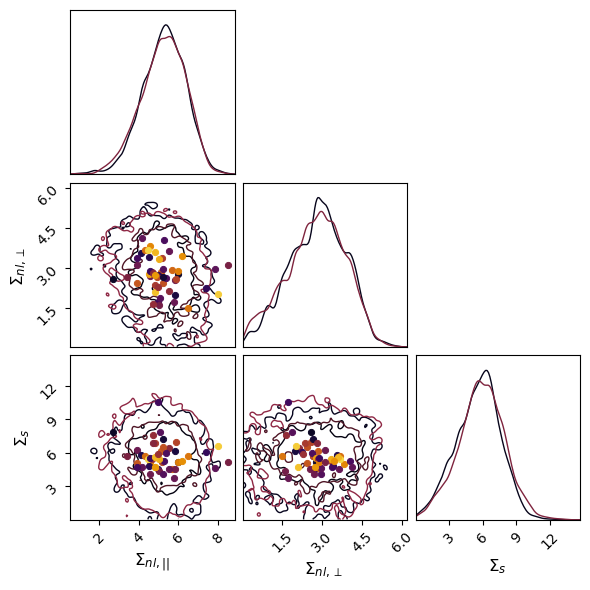

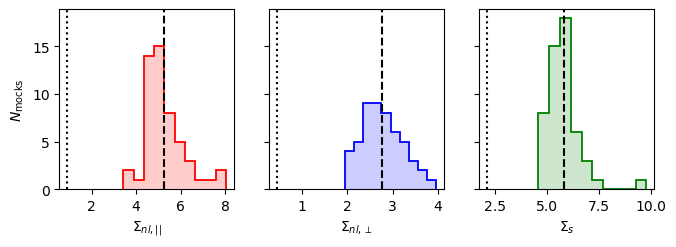

[5.26561992 2.76873085 5.82400156 1.08144436 1.06034467 1.98654238]
[0.91589131 0.45688965 0.82251759 0.08322194 0.04742863 0.1331266 ]


In [8]:
def plot_errors(stats, suffix='_bestnuisance'):
    
    nstats = len(stats)
    means = np.mean(stats, axis=0)
    covs = np.cov(stats, rowvar=False)
    corr = covs[0, 1] / np.sqrt(covs[0, 0] * covs[1, 1])

    labels = [r"$\Sigma_{nl,||}$", r"$\Sigma_{nl,\perp}$", r"$\Sigma_s$"] 
    colors = ["r", "b", "g"]
    
    fig, axes = plt.subplots(figsize=(7, 2), nrows=1, ncols=len(labels), sharey=True, squeeze=False)
    
    plt.subplots_adjust(left=0.1, top=0.95, bottom=0.05, right=0.95, hspace=0.3)
    
    stds_arr = [np.sqrt(covs[0, 0]), np.sqrt(covs[1, 1]), np.sqrt(cov[2,2])]
    
    for ax, vals, avgs, stds, l, c in zip(axes.T, np.array(stats).T, means, stds_arr, labels, colors):

        ax[0].hist(vals, 10, color=c, histtype="stepfilled", alpha=0.2, density=False, zorder=0)
        ax[0].hist(vals, 10, color=c, histtype="step", alpha=1.0, lw=1.3, density=False, zorder=1)
        ax[0].axvline(avgs, color="k", ls="--", zorder=2)
        ax[0].axvline(stds, color="k", ls=":", zorder=2)
        ax[0].set_xlabel(l)
        
    axes[0, 0].set_ylabel(r"$N_{\mathrm{mocks}}$")

    plt.savefig("plots/desi_kp4_abacus_cubic_ELG"+suffix+"/output/histplot.png", bbox_inches='tight')
    plt.show()

    return nstats, means, covs, corr

truth = {"$\\Sigma_{nl,||}$": 1.0, "$\\Sigma_{nl,\\perp}$": 0, "$\\Sigma_s$": 1.0}

parameters = [names for names in truth]

for chain_bin in range(len(c)):
    
    if 'Pk' not in datanames[chain_bin]:
        continue 

    suffix = '_bestnuisance'
    c[chain_bin].plotter.plot(
    #truth=truth,
        parameters=parameters,
        legend=False,#True,
        display=True,
        figsize=(6,6), 
        filename="plots/desi_kp4_abacus_cubic_ELG" + suffix + "/output/contourplot_v2.png",
        
    )
    
    # Plot histograms of the errors and r_off
    nstats, means, covs, corr = plot_errors(stats[datanames[chain_bin]])
    print(means)
    print(np.sqrt(np.diag(covs)))

    with open("plots/desi_kp4_abacus_cubic_ELG_bestnuisance/output/Barry_fit_" + datanames[chain_bin] + ".txt", "w") as f:
        f.write(
            "# Realisation, Sigma_nl_para, Sigma_nl_perp, sigma_s, sig_Sigma_nl_para, sig_Sigma_nl_perp, sig_Sigma_s, bf_chi2, dof\n"
            )
        for l in output[datanames[chain_bin]]:
            f.write(l + "\n")

        # And now the average of all the individual realisations
        f.write("# ---------------------------------------------------\n")
        f.write(
            "# <Sigma_nl_par>, <Sigma_nl_perp>, <Sigma_s>, <sig_Sigma_nl_para>, <sig_Sigma_nl_perp>, <sig_Sigma_s>, std_sigma_nl_para, std_sigma_nl_perp, std_sigma_s\n"
            )
        f.write(
            f"{means[0]:6.4f}, {means[1]:6.4f}, {means[2]:6.4f}, {means[3]:6.4f}, {means[4]:6.4f}, {means[5]:6.4f}, {np.sqrt(covs[0, 0]):6.4f}, {np.sqrt(covs[1, 1]):6.4f}, {np.sqrt(covs[2,2]):6.4f}\n"
            )